## 1. Выравнивание ридов RNA-Seq


`hisat2-build ref.fa ref` - индексирование

`hisat2 -x ref -1 SRR453566_1.fastq -2 SRR453566_2.fastq -S alignment.sam` - выравнивание

`!samtools view -S -b /content/drive/MyDrive/ngs_7/alignment.sam > alignment.bam`

`samtools sort alignment.bam -o alignment_sorted.bam`

`!samtools index alignment_sorted.bam`

перевод в bam формат и сортировка

## 2. Оценка количества экспрессирующихся генов

In [ ]:
import numpy as np
import pandas as pd
import pysam
from Bio import SeqIO
import gffutils

In [3]:
from IPython.display import Image

In [25]:
db = gffutils.create_db("/content/drive/MyDrive/ngs_7/genes.gtf", dbfn='genes.db', merge_strategy="create_unique")

/usr/local/lib/python3.7/site-packages/gffutils/create.py:734: UserWarning: It appears you have a gene feature in your GTF file. You may want to use the `disable_infer_genes=True` option to speed up database creation
  "It appears you have a gene feature in your GTF "
/usr/local/lib/python3.7/site-packages/gffutils/create.py:725: UserWarning: It appears you have a transcript feature in your GTF file. You may want to use the `disable_infer_transcripts=True` option to speed up database creation
  "It appears you have a transcript feature in your GTF "


In [3]:
alignment = pysam.AlignmentFile("/content/alignment_sorted.bam", "rb")
ref_seq = next(SeqIO.parse("/content/drive/MyDrive/ngs_7/ref.fa", "fasta")).seq
gen_db = gffutils.FeatureDB("genes.db")

In [4]:
RPKM, coverage = [], []
for gene in gen_db.features_of_type(featuretype="gene"):
  s, e = gene.start, gene.end
  seq_id = gene.seqid
  gen_reads = set()
  gen_coverage = [0 for i in range(e-s)]
  for col in alignment.pileup(seq_id, start=s-1, stop=e-1, truncate=True):
    gen_reads.update(col.get_query_names())
    gen_coverage[col.pos-s] = col.get_num_aligned()
  coverage.append(np.count_nonzero(gen_coverage)/len(gen_coverage))
  RPKM.append(len(gen_reads)/((e-s)/1000))

In [13]:
scaling_factor = sum(RPKM)/1000000
TPM = [rpkm/scaling_factor for rpkm in RPKM]
hit_1 = 0
hit_2 = 0
high_cov = 0.99 # далее рассматриваются гены с покрытием выше high_cov
median_TPM = np.median(TPM)
min_TPM = 5
for c, t in zip(coverage, TPM):
  if c > high_cov and t > min_TPM:
    hit_1 += 1
  if c > high_cov and t > median_TPM:
    hit_2 += 1

In [9]:
np.median(TPM)

35.6864780104737

In [22]:
hit_1

6631

In [21]:
hit_2

3552

Медианное значение TPM около 36. 

3552 гена экспрессируются с уровнем экспресии выше 36.

Значение TPM, равное 5, выбрано в качестве отметки для генов с низкой экспрессией. Количество генов с TPM меньше 5 составляет 6631, или около 93% от общего числа генов.

## 3. Сборка de novo

`/content/SPAdes-3.15.2-Linux/bin/rnaspades.py -1 SRR453566_1.fastq -2 SRR453566_2.fastq -o rna_res`

`./rnaQUAST-2.2.0/rnaQUAST.py -r drive/MyDrive/ngs_7/ref.fa --gtf drive/MyDrive/ngs_7/genes.gtf -c rna_res/transcripts.fasta -o rnaQ_res` 

Количество покрытых генов примерно равно количеству генов с уровнем экспрессии выше медианного значения TPM.

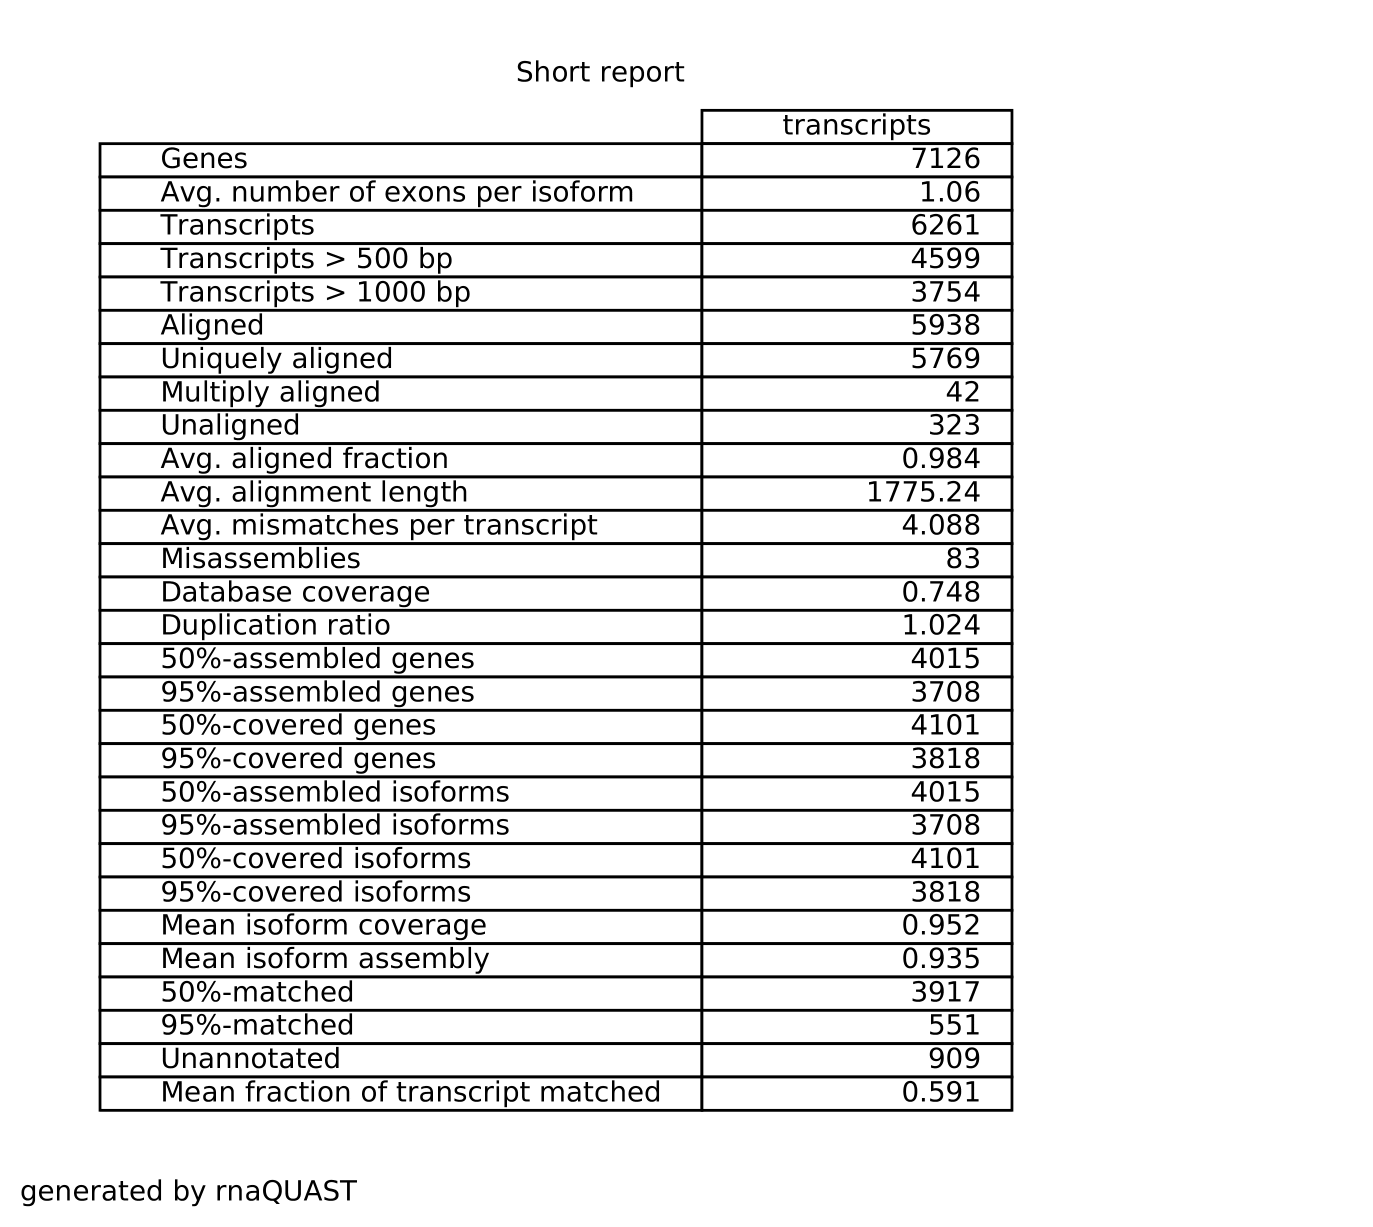

In [4]:
Image('short_report-1-1.png')